# Simple example that the technique works

## Importing

In [1]:
import sys
import os
sys.path.insert(0, os.path.pardir)

In [2]:
import torch
import numpy as np
from etnn.nn.layer_framework import LayerManagementFramework, TreeNode
import random
import matplotlib.pyplot as plt
from etnn.tools.training_tools import seeding_all

## Data creation

In [3]:
# create elements
a = torch.tensor([1., 2., -3., 4., 5., 6.])
b = torch.tensor([2., -3., 4., 5., 6., 7.])
c = torch.tensor([ 3., 4., 5., 6., -7., 8.])
d = torch.tensor([-1., -2., -3., -4., -5., -6.])

In [4]:
# data creation through stacking elements
data = torch.stack([
    torch.stack([a, b, c, d]),
    torch.stack([d, a, b, c]),
    torch.stack([c, d, a, b]),
    torch.stack([b, c, d, a]),

    torch.stack([d, b, c, a]),
    torch.stack([a, d, b, c]),
    torch.stack([c, a, d, b]),
    torch.stack([b, c, a, d]),
])
labels = torch.tensor([
    0.,
    0.,
    0.,
    0.,
    30.,
    30.,
    30.,
    30.
])
data_test = torch.stack([
    torch.stack([d,c,b,a]),
    torch.stack([a,c,b,d])
])
labels_test = torch.tensor([
    0.,
    30.
])

In [13]:
# label_type = "S"
# label_type = "Q"
label_type = "C"
label_type = "P"

In [14]:
# construct tree:
tree = TreeNode(label_type, [TreeNode("E", 4)])

## Training and evaluation

In [15]:
num_epochs = 1000
learning_rate = 0.001

### ETNN

In [16]:
# test run for both models
print("etnn")
train_loss_storage_etnn = []
test_loss_storage_etnn = []

# seed for fair comparison and reproducability
seeding_all()

etnn_model = LayerManagementFramework(
    in_dim=6,
    tree=tree,
    hidden_dim=10,
    out_dim=1,
    k=2
)
print(f"parameter counter: {sum([p.numel() for p in etnn_model.parameters()])}")

# create optimizer and loss
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(etnn_model.parameters(), lr=learning_rate)

# do for some epochs
for epoch in range(num_epochs):
    # train
    optimizer.zero_grad()
    etnn_model.train()
    out = etnn_model(data)
    train_loss = criterion(out.flatten(), labels)
    train_loss_storage_etnn += [train_loss.item()]
    train_loss.backward()
    optimizer.step()

    # test
    with torch.no_grad():
        etnn_model.eval()
        test_loss = criterion(etnn_model(data_test).flatten(), labels_test)
        test_loss_storage_etnn += [test_loss.item()]
    # print(f"epoch: {epoch}| train_loss: {train_loss} | test_loss: {test_loss} \nvalues: {out.flatten().detach().cpu().tolist()}")

etnn
parameter counter: 360


### Baseline

In [17]:
# test run for both models
print("baseline")
train_loss_storage_baseline = []
test_loss_storage_baseline = []

# seed for fair comparison and reproducability
seeding_all()

baseline = torch.nn.Sequential(
    torch.nn.Linear(6*4,9*2),
    torch.nn.ReLU(),
    torch.nn.Linear(9*2, 1)
)

print(f"parameter counter: {sum([p.numel() for p in baseline.parameters()])}")

# create optimizer and loss
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(baseline.parameters(), lr=learning_rate)

# do for some epochs
for epoch in range(num_epochs):
    # train
    optimizer.zero_grad()
    baseline.train()
    out = baseline(data.reshape(data.shape[0], -1))
    train_loss = criterion(out.flatten(), labels)
    train_loss_storage_baseline += [train_loss.item()]
    train_loss.backward()
    optimizer.step()

    # test
    with torch.no_grad():
        etnn_model.eval()
        test_loss = criterion(baseline(data_test.reshape(data_test.shape[0], -1)).flatten(), labels_test)
        test_loss_storage_baseline += [test_loss.item()]
    # print(f"epoch: {epoch}| train_loss: {train_loss} | test_loss: {test_loss} \nvalues: {out.flatten().detach().cpu().tolist()}")

baseline
parameter counter: 469


## Results

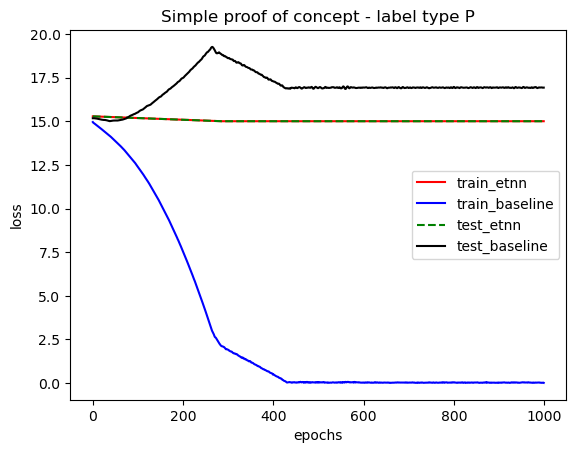

In [18]:
# plot stuff
plt.figure()
plt.plot(train_loss_storage_etnn, c='r', label="train_etnn")
plt.plot(train_loss_storage_baseline, c='b', label="train_baseline")

plt.plot(test_loss_storage_etnn, c='green', label="test_etnn", linestyle='dashed')
plt.plot(test_loss_storage_baseline, c='black', label="test_baseline")
plt.title(f"Simple proof of concept - label type {label_type}")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()